For this task I have chosen to implement an RBFN over an MLP. I chose RBF not for any analytical or practical purpose but because they were new to me and I wanted to challenge myself in implementing not just RBF but the hybrid style of training, using unsupervised learning is something that I have not before had the chance to do and so I felt intrigued by this area especially. Had I had the luxry of time I would have implemented both models and used the one which generalised the best out of the two.

In [1]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import pickle
from collections import defaultdict

Import all libraries needed for this task

In [2]:
data = []
with open('data105882.csv','rb') as dataset:
    dataReader = csv.reader(dataset)
    for row in dataReader:
        data.append(row)
for i in range(len(data)):
    for j in range(len(data[i])):
        data[i][j] = float(data[i][j])

data = np.array(data)
labels = data[:,7]
data = data[:,:7]

The above reads in data, creating a 7D feature matrix and a corresponding ground truth vector such that $labels_i$ is the ground truth for $x_i$

In [3]:
def whiten(dataCov,data):
    #newData = data.copy()
    d,u = np.linalg.eig(dataCov)
    c1 = np.sqrt(d)
    c1 = 1/c1
    c1 = np.diag(c1)
    meanRow = [np.mean(data[:,i])for i in range(7)]
    means = []
    for i in range(len(data)):
        means.append(meanRow)
    means = np.array(means)
    newData = []
    for i in range(len(data)):
        newData.append(np.matmul(c1,np.matmul(u.transpose(),(data[i]-means[i]))))    
    newData = np.array(newData)
    
    return newData

The above cell defines the function for whitening the data. This removes all correlation in the data and ensures that all features have a zero mean. The below cell calls this function and divides by the standard devation, giving unit length standard deviation for all features.

In [4]:
data = whiten(np.cov(data,rowvar=False),data)
cov = np.cov(data, rowvar=False)
for i in range(len(data[0])):
    sig = np.std(data[:,i])
    data[:,i]= data[:,i]/sig

My function definition and implementation of kmeans is below. Centres are initialised to random points on the first iteration,with datapoints assigned to the nearest cluster. The centres are then moved a distance, closer to each data point scaled by the parameter $\eta$. The stopping criterion is when there is no change to the points assigned to each centre. Selecting $\eta$ resulted in a trade off between convergence time and potentially having a more sparsely distributed set of centers (potential as they were initialised randomly). By setting the $\eta$ value too low, k-means would converge too quickly as the centres would hardly move, resulting in what is essentially a random assignment of centres. Too high and it would be very slow to converge as the centres would be moving around the space for a long time before eventually converging.

In [5]:
def kmeans(k):
    c = np.random.randint(0,len(data),size=k)
    centres = []
    centres+=(data[i]for i in c)
    centres = np.array(centres)
    eta = 0.000001
    sse = 0
    vals_at_cent = defaultdict(list)
    new_vals_at_cent = defaultdict(list)
    #count = 0
    match = False
    while not match:
        #print count
        cents = []
        new_vals_at_cent.clear()
        for i in range(len(data)):
            nearest = 0
            nearest_dist = np.inf
            for j in range(len(centres)):
                dist = scipy.spatial.distance.euclidean(data[i],centres[j])
                if dist < nearest_dist:
                    nearest = j
                    nearest_dist = dist
            deltC = eta*(data[i]-centres[nearest])
            centres[nearest] += deltC
            sse+= nearest_dist**2
            cents.append(nearest)
            new_vals_at_cent[nearest].append(data[i].tolist())
        for r in range(k):
            if vals_at_cent[r] == new_vals_at_cent[r]:
                match = True
            else:
                #print 'cent ',r,' does not match'
                match = False
                break
        vals_at_cent = new_vals_at_cent.copy()
        #count += 1
    #plt.scatter(data[:,0], data[:,1])
    #plt.scatter(centres[:,0],centres[:,1], c='r')
    return centres,sse, vals_at_cent,cents


In [6]:
kVals = np.arange(100,1100,step=100)

'''errs = []
for k in kVals:
    centres,sse, vals_at_cent,cents = kmeans(k)
    errs.append(sse)'''
errs = pickle.load(open('kTest.pickle','rb'))

Running the kMeans algorithm with multiple values for $k$ and assessing the Sum of Square errors for each $k$ value. The SSE is computed by summing the squared distance between each datapoint and it's center. As this test took a lengthy amount of time to compute, the outputs have been saved using pickle. The code has been left in tact but commented out in the event the reader of this document wishes to run the test for themselves.

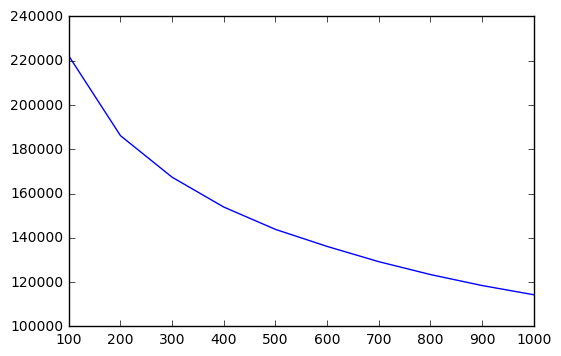

In [7]:
plt.plot(kVals,errs)

As the value of $k$ increases, the SSE decreases. This is expected as when $k$ approaces $N$, the SSE approached $0$. At which point we are merely implementing a full interpolation model of the RBFN. A value of 200 centres was chosen as this is where the error curve has the steepest gradient. 

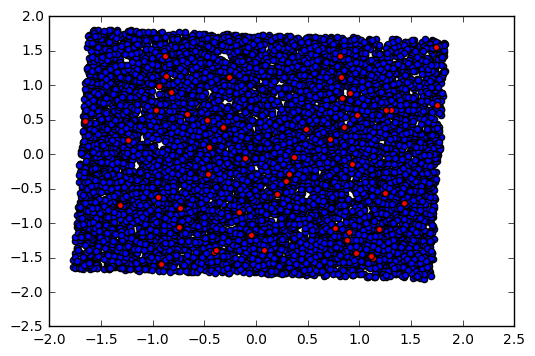

In [8]:
centres, sse, vals_at_cent,cents = kmeans(50)
centres = np.array(centres)

plt.scatter(data[:,0], data[:,1])
plt.scatter(centres[:,0],centres[:,1], c='r')

The above takes the data and applies k-means to assign each datapoint to a cluster. The above plot is a snapshot of the data in its first two dimensions with the locations of the centres in the same dimensions in red.

Note how k-means was launched with only $k=50$ rather than the $k=200$ stated above. This was due to a fundamental error that I was unable to resolve whereby after computing the mahalanobis distance, the distance matrix was being populated with NaN values for the distance from all datapoints to certain centres. Furthermore it appeared that the centres affected were the ones that had a very low number of datapoints assigned to them. After spending many hours attempting to resolve the problem, I beleive it to either be related to:

* Negative values in the inverse of the covariance matrix for the given feature which when square rooted inside the 'cdist' function, results in a complex number, which python treats as NaN (even if it didn't would not be of any use).


* Although the previous point implies a fundamental flaw with my k-means algorithm, there could be a separate unreleated issue in my implementation which has caused this behaviour.

This issue has, I believe had a huge impact on the overall efficay of the model and many hours were spent trying to remedy the situation. A point was reached where a decision was made to continue on with the rest of the task despite this error. While still present in the implementation, lowering the number of centres to 50 proved to at the least ease the problem, although even with a $k=50$, the model will still occasionally throw an error due to NaN's being present in the distance matrix. Although I could have resorted to using a toolbox such as SciKit, I decided to stick with my implementation as, as flawed as it may be, I believe it still shows some understanding of the methodology.

In [ ]:
dist_mat =[]
for i in range(len(centres)):
    cent_inv = np.linalg.inv(np.cov(vals_at_cent[i], rowvar= False))
    cdist = scipy.spatial.distance.cdist(data,centres,metric='mahalanobis',VI=cent_inv)
    dist_mat.append(cdist[:,i])
dist_mat = np.array(dist_mat)
dist_mat = dist_mat.transpose()

sigma = 0.5
    
phi = np.exp(-((dist_mat**2)/2*(sigma**2)))
phinv = np.linalg.pinv(phi)
w = np.matmul(phinv,labels)
y= phi.dot(w)

The above cell, computes the distance and phi matrices, weights and outputs for the data.

In [11]:
def calc_err(outs,targs):
    error = 0
    for i in range(len(targs)):
        error += (outs[i] - targs[i])**2
    error = error/len(targs)
    return error

The above function takes the outputs and the ground truth as arguments and computed the Mean Square Error.

The below cell is the main function used for cross validation.

The function takes a value $k>1$, which determines how many 'folds' to split the data in to, it also takes the data and associated ground truth outputs as well as $\sigma$ used in calculating the phi matrix, a boolean 'regularise' and $\lambda$ a regularisation paramter in the event that we wish to regularise.

The function splits the data into $k$ folds and uses $k-1$ of them as training data, with the last being used as testing data. The error is then recorded and the process repeated such that it runs $k$ times and returns the mean of the testing errors.

In [28]:
def kfold(k,data,labels,sigma,regularise,lam):
    order = np.random.permutation(len(data)).tolist()
    error = []
    train_error = []
    for j in range(k):
        test = []
        test_lab = []
        test_indices = []
        sigs = []
        train = []
        train_lab = []
        for i in range(len(data)/k):
            test.append(data[order[0]])
            test_lab.append(labels[order[0]])
            test_indices.append(order.pop(0))
        for i in range(len(order)):
            train.append(data[order[i]])
            train_lab.append(labels[order[i]])
       
        test_mat = np.array(test)
        test_lab_mat = np.array(test_lab)
        
        train_mat = np.array(train)
        train_lab_mat = np.array(train_lab)
        
        train_cov = np.cov(train_mat,rowvar=False)
        train_mat = whiten(train_cov, train_mat)
        
        for i in range(len(train_mat[0])):
            sig = np.std(train_mat[:,i])
            sigs.append(sig)
            train_mat[:,i]= train_mat[:,i]/sig
        
        centres,sse, vals_at_cent,cents = kmeans(50)
        
        
        dist_mat =[]
        for i in range(len(centres)):
            cent_inv = np.linalg.inv(np.cov(vals_at_cent[i], rowvar= False))
            cdist = scipy.spatial.distance.cdist(train_mat,centres,metric='mahalanobis',VI=cent_inv)
            dist_mat.append(cdist[:,i])
        dist_mat = np.array(dist_mat)
        dist_mat = dist_mat.transpose()       
        
        phi = np.exp(-((dist_mat**2)/2*(sigma**2)))
        phinv = np.linalg.pinv(phi)
        if not regularise:
            w = np.matmul(phinv,train_lab)
        else:
            t1 = np.matmul(phi.transpose(),phi)
            t2 = np.linalg.inv(t1+lam*np.identity(len(centres)))
            t3 = np.matmul(phi.transpose(),train_lab_mat)
            w = np.matmul(t2,t3)
        y = np.dot(phi,w)
        train_error.append(calc_err(y,train_lab))        
        test_mat = whiten(train_cov,test_mat)
        
        #----- preprocess based on training data -----#
        for i in range(len(test_mat[0])):
            test_mat[:,i]= test_mat[:,i]/sigs[i]
        
        dist_mat =[]
        for i in range(len(centres)):
            cent_inv = np.linalg.inv(np.cov(vals_at_cent[i], rowvar= False))
            cdist = scipy.spatial.distance.cdist(test_mat,centres,metric='mahalanobis',VI=cent_inv)
            dist_mat.append(cdist[:,i])
        dist_mat = np.array(dist_mat)
        dist_mat = dist_mat.transpose()       
        
        phi = np.exp(-((dist_mat**2)/2*(sigma**2)))
        y = np.dot(phi,w)
        error.append(calc_err(y,test_lab))
        
        for i in range(len(test_indices)):
            order.append(test_indices.pop(0))
    return np.mean(error), np.mean(train_error)

The below cell fits the model a number of times using different sigma values for the Gaussian RBFs. It stores the mean error for each sigma value which is then plotted as a way of visualising the change in error with respect to $\sigma$.

In [30]:
sigma_vals = np.arange(0,0.0001,step=0.00002)

errors = []
train_errors = []
for i in range(len(sigma_vals)):
    e,te =(kfold(5,data.copy(),labels.copy(),sigma_vals[i],False,None))
    errors.append(e)
    train_errors.append(t)

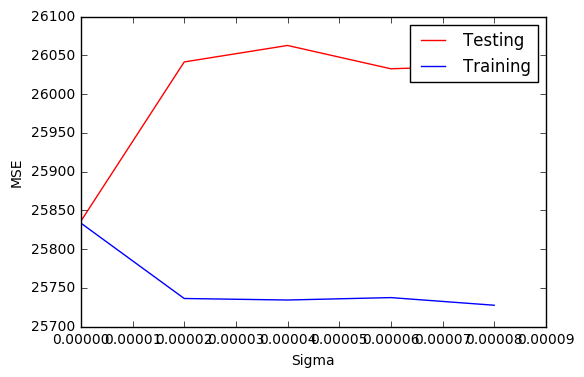

In [36]:
plt.plot(sigma_vals,errors,'r-', label = 'Testing')
plt.plot(sigma_vals,train_errors,'b-', label = 'Training')
plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.legend()
plt.show()

The $\sigma$ values were initially tested with values between $0.2$ and $1$ with a step size of $0.2$, the resulting plot from this showed that as the value for $\sigma$ decreased, the testing error also decreased. At a value of $0.2$, the error was over $100,000$. This was gradually reduced to the point where a value of $0.00002$ was used. Altough the error was still high at around $25,800$.

Next, add a regularisation term....

In [51]:
lam_vals = np.arange(0.1,1,step = 0.2)
errors = []
train_errors = []
for i in range(len(lam_vals)):
    e,te = kfold(5,data.copy(),labels.copy(),0.0001,True,lam_vals[i])
    errors.append(e)
    train_errors.append(te)

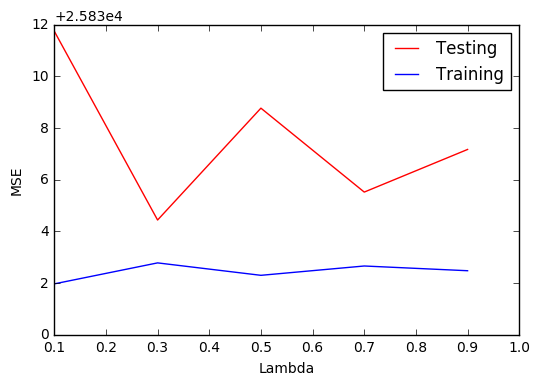

In [52]:
plt.plot(lam_vals,errors,'r-', label = 'Testing')
plt.plot(lam_vals,train_errors,'b-', label = 'Training')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.legend()
plt.show()

A number of ranges were tried for regularisation ranging from $0.0001$ to values as high as $2$. In the case of this model, regularisation appeared to have no benefit to generalisation. I suspect that this may be again due to flaws in the model implementation that I am unaware of of unable to spot.

In [73]:
data = []
with open('data105882.csv','rb') as dataset:
    dataReader = csv.reader(dataset)
    for row in dataReader:
        data.append(row)
for i in range(len(data)):
    for j in range(len(data[i])):
        data[i][j] = float(data[i][j])

data = np.array(data)
labels = data[:,7]
data = data[:,:7]


data = whiten(np.cov(data,rowvar=False),data)
cov = np.cov(data, rowvar=False)
for i in range(len(data[0])):
    sig = np.std(data[:,i])
    data[:,i]= data[:,i]/sig

centres,sse, vals_at_cent,cents = kmeans(50)

dist_mat =[]
for i in range(len(centres)):
    cent_inv = np.linalg.inv(np.cov(vals_at_cent[i], rowvar= False))
    cdist = scipy.spatial.distance.cdist(data,centres,metric='mahalanobis',VI=cent_inv)
    dist_mat.append(cdist[:,i])
dist_mat = np.array(dist_mat)
dist_mat = dist_mat.transpose()       
        
phi = np.exp(-((dist_mat**2)/2*(0.00002**2)))
phinv = np.linalg.pinv(phi)

w = np.matmul(phinv,labels)

with open("cov.pickle","wb") as cFile:
    pickle.dump(cov,cFile)


with open("weights.pickle","wb") as wFile:
    pickle.dump(w,wFile)

# TEST DATA HERE

In [74]:
test_data = []
with open('testdata.csv','rb') as dataset:
    dataReader = csv.reader(dataset)
    for row in dataReader:
        test_data.append(row)
for i in range(len(data)):
    for j in range(len(data[i])):
        test_data[i][j] = float(data[i][j])

        
with open("cov.pickle","rb") as cFile:
    cov = pickle.load(cFile)
    
with open("weights.pickle","rb") as wFile:
    w = pickle.load(wFile)
    
test_data = np.array(data)
test_data = whiten(cov,test_data)

dist_mat =[]
for i in range(len(centres)):
    cent_inv = np.linalg.inv(np.cov(vals_at_cent[i], rowvar= False))
    cdist = scipy.spatial.distance.cdist(test_data,centres,metric='mahalanobis',VI=cent_inv)
    dist_mat.append(cdist[:,i])
dist_mat = np.array(dist_mat)
dist_mat = dist_mat.transpose()

phi = np.exp(-((dist_mat**2)/2*(0.00002**2)))

y = np.dot(phi,w)